# Introduction

Having a healthy life style has been a growing trend in the last few years, it has been related to making improvements not only from a health perspective but in most aspects of our daily life from better work performance, self-confidence and many other things. And with the recent covid-19 pandemic and the great increase in people that now work from home a new opportunity for Gyms has been opening up.

Gyms are the go to place for people seeking this aforementioned life improvements, most people used to go to the gyms after they left their jobs in their offices, but with the covid-19 pandemic and work from home this routine has been hardly hit, people no longer could go to the gyms and if they could they found out that they would now have to make long trips to attend to the gyms they used to. Here is where opportunity comes into play, people are looking for gyms closer to their new workplace, their homes.

In this project we explore a dataset of gyms in New York city, and find out where most gyms are, what are the best gyms, do people have access to good gyms where they live? this will allow us to know where would be best to start a new gym considering several aspects ranging from competition to possible demand.


# Data

To find the best place to open a gym we will use:

 -  A New York city dataset obtained from https://cocl.us/new_york_dataset containing the neighborhoods, and boroughs of the city along with the respective latitudes and longitudes that will be needed.
 
 - Gym data, ranging from location and names to ratings and likes, will be acquired from the FourSquare API.

# Methodology

 -  New York Data will be obtained from https://cocl.us/new_york_dataset cleaned and processed into a dataframe.

 -  FourSquare be used to obtain all the gyms in the city. Ratings, tips, and likes by users will be counted and added to the dataframe.

 -  Data will be sorted based on ratings.

 -  the data be will be visually assessed using graphing from Python libraries.
 
 - The New York Population estimates for 2019 from https://bit.ly/3fT0VPJ giving us the population estimates of each of New York Boroughs.

# Problem Statement

1. What is / are the best location(s) for a Gym in New York City?
2. In what Neighborhood and/or borough should the investor open a Gym to have the best chance of being successful?
3. Where would I go in New York City to find the best Gym?

#### Import libraries and everything that will be used

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         235 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.4.13-~ --> conda-forge::ca-certificates-

#### Download the New york data

In [2]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
features=resp['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
NY_data = pd.DataFrame(columns=column_names)
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    NY_data = NY_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
NY_data.head() 

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Define our Foursquare Credentials

In [3]:
CLIENT_ID = 'UTVPTGZSQNBIH44U2VKDPBL0FUD3DXAXQDFT0DXJKKMEAUIA' # your Foursquare ID
CLIENT_SECRET = 'N4ZJC504I5KMFLJFEXQA0FN2BKLRWXMFSITPKHQVHS1PUDXG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UTVPTGZSQNBIH44U2VKDPBL0FUD3DXAXQDFT0DXJKKMEAUIA
CLIENT_SECRET:N4ZJC504I5KMFLJFEXQA0FN2BKLRWXMFSITPKHQVHS1PUDXG


#### Declare some functions for easier acquisition of the data from foursquare, First to get geo location an adress

In [4]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### To get venues, and its details

In [5]:
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### We acquire the Data of the NYC gyms

In [6]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
gym_ny=pd.DataFrame(columns=column_names)      
count=1
for row in NY_data.values.tolist():                       
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    gyms=venues[venues['Category']=='Gym']    
    print('(',count,'/',len(NY_data),')','Gyms in '+Neighborhood+', '+Borough+':'+str(len(gyms)))  
    print(row)
    for Gym_detail in gyms.values.tolist():
        id, name , category=Gym_detail
        gym_ny = gym_ny.append({'Borough': Borough,
                            'Neighborhood': Neighborhood, 
                            'ID': id,
                            'Name' : name
                           }, ignore_index=True)
    count+=1

( 1 / 306 ) Gyms in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Gyms in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Gyms in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Gyms in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Gyms in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Gyms in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Gyms in Marble Hill, Manhattan:1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Gyms in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Gyms in Norwood, Bronx:0
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 / 306 ) Gyms in Williamsbridge, Bronx:0
['Bronx', 'Williamsbridge', 40.88

#### The data we acquire from foursquare will be stored in csv files to avoid problems with foursqure data acquisition limitations

In [7]:
gym_ny.to_csv('gym_ny_tocsv1_old.csv')

#### A previusly saved csv will be used to avoid possible problems

#### Now we analyze our data, first lets check everything is in order and how many gyms are there

In [8]:
gym_ny = pd.read_csv('gym_ny_tocsv1.csv', index_col = 0)
gym_ny.tail()

,Borough,Neighborhood,ID,Name
91,Manhattan,Flatiron,4af0e05cf964a520d7df21e3,New York Health and Racquet Club
92,Queens,Sunnyside Gardens,4b6cb85bf964a520f24e2ce3,Phyzique
93,Brooklyn,Dumbo,574da288498eda5b31e1da24,Equinox Dumbo
94,Brooklyn,Dumbo,4e2313d4c65b2b5e355768b3,CrossFit Dumbo
95,Manhattan,Hudson Yards,4c0870ae340720a1703f8393,505W37 Gym


Lets drop that extra column

In [9]:
gym_ny.shape

(96, 4)

#### How many gyms are there per Borough?

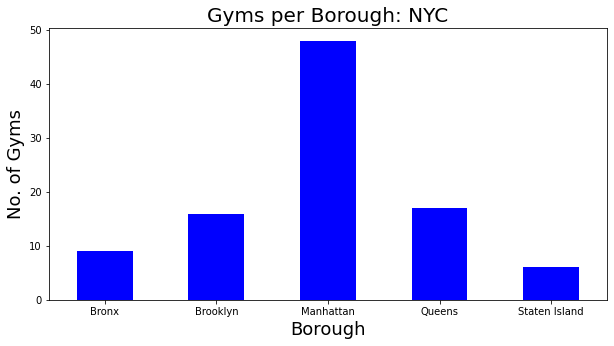

In [10]:
gym_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='blue')
plt.title('Gyms per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 18)
plt.ylabel('No. of Gyms', fontsize=18)
plt.xticks(rotation = 'horizontal')
plt.show()

#### How about per neighborhood?

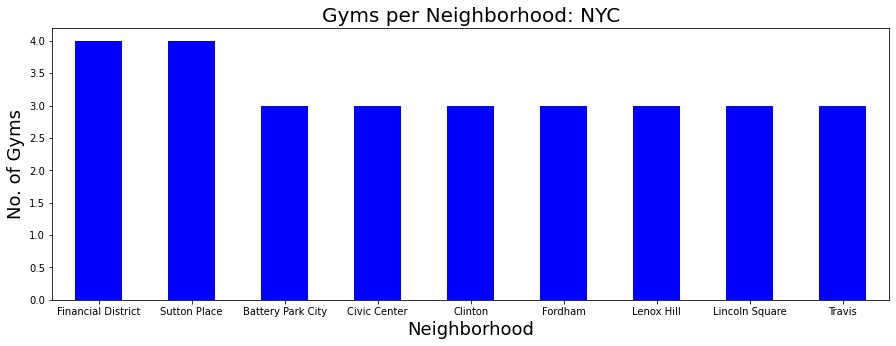

In [11]:
Max = 9  
gym_ny.groupby('Neighborhood')['ID'].count().nlargest(Max).plot.bar(figsize=(15,5), color='blue') #nlargest(NOofNeigh)
plt.title('Gyms per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 18)
plt.ylabel('No. of Gyms', fontsize=18)
plt.xticks(rotation = 'horizontal')
plt.show()

#### We can see that most gyms are in the Manhattan Borough and also Manhattan has the neighborhoods with the most amount of Gyms 

#### Lets take a closer look into the gyms What do the people think of them? lets aquire the data from foursquare and find out.

In [12]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
gym_stats_ny=pd.DataFrame(columns=column_names)
count=1 
#Due to Foursquare limit of 50 calls per day we will split our data list in two
#and extract the data separately and put it together afterwards
gym_ny_tail = gym_ny.tail(47)             #Comment this line and replace the next comment line for part 1
for row in gym_ny_tail.values.tolist():    #gym_ny.values.tolist():  
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0] #0
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(gym_ny),')','processed')
    gym_stats_ny = gym_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
gym_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60a6e0394fc3bf06f763f605'}, 'response': {'venue': {'id': '506ce45b45b0b18fd2dc0081', 'name': 'Crossfit Wall Street', 'contact': {}, 'location': {'address': '60 New St', 'crossStreet': 'Beaver st', 'lat': 40.70554386423745, 'lng': -74.01213909064103, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70554386423745, 'lng': -74.01213909064103}], 'postalCode': '10004', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 New St (Beaver st)', 'New York, NY 10004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crossfit-wall-street/506ce45b45b0b18fd2dc0081', 'categories': [{'id': '4bf58dd8d48988d176941735', 'name': 'Gym', 'pluralName': 'Gyms', 'shortName': 'Gym', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://crossfitwallstreet.com', 'likes': {'count': 14, 'groups': [{'ty

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
42,Manhattan,Flatiron,4af0e05cf964a520d7df21e3,New York Health and Racquet Club,195,8.4,34
43,Queens,Sunnyside Gardens,4b6cb85bf964a520f24e2ce3,Phyzique,36,7.2,9
44,Brooklyn,Dumbo,574da288498eda5b31e1da24,Equinox Dumbo,91,9.1,15
45,Brooklyn,Dumbo,4e2313d4c65b2b5e355768b3,CrossFit Dumbo,23,8.7,3
46,Manhattan,Hudson Yards,4c0870ae340720a1703f8393,505W37 Gym,15,7.4,3


In [13]:
gym_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Financial District,506ce45b45b0b18fd2dc0081,Crossfit Wall Street,14,8.4,2
1,Manhattan,Financial District,521b898a8bbdce5bf8e95c58,Complete Body,80,8.6,6
2,Manhattan,Financial District,5587da4f498e9d88e373b269,Pure Barre Financial District,32,7.8,6
3,Queens,Astoria,4c94d26d58d4b60c40fc2b29,CrossFit Queens,49,8.8,7
4,Queens,Astoria,4d7ce85486cfa14365a2d2a0,Simply Fit Astoria,32,8.3,11


In [14]:
gym_stats_ny.to_csv('gym_stats_ny_csv_old.csv')

In [15]:
gym_stats_ny.shape

(47, 7)

#### A previusly saved csv will be used to avoid possible problems

#### the two parts of the venue details are put together in one dataframe

In [16]:
gym_stats_ny_start = pd.read_csv('gym_stats_ny_csv.csv', index_col = 0)
gym_stats_ny_end = pd.read_csv('gym_stats_ny_csv2.csv', index_col = 0)
gym_stats_ny = pd.concat([gym_stats_ny_start, gym_stats_ny_end], ignore_index = True) 
gym_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Marble Hill,4cf6ae55d3a8a1cd71a9d243,Astral Fitness & Wellness Center,6,7.5,1
1,Bronx,Fordham,52af0e3c11d2fb9a346ce0f7,Blink Fitness,25,7.6,4
2,Bronx,Fordham,4d94c27b0d7ed7cea8ddfb46,Lucille Roberts,14,7.7,0
3,Bronx,High Bridge,5769027ccd106670100ea1af,Retro Fitness,1,6.8,1
4,Bronx,Melrose,542c31e1498e76106c273492,Blink Fitness,1,7.2,0


In [17]:
gym_stats_ny.shape

(97, 7)

#### What data type is the data we acquired in?

In [18]:
gym_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       97 non-null     object 
 1   Neighborhood  97 non-null     object 
 2   ID            97 non-null     object 
 3   Name          97 non-null     object 
 4   Likes         97 non-null     int64  
 5   Rating        97 non-null     float64
 6   Tips          97 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 5.4+ KB


#### We'll convert the data type of the tips and the likes into float to ease our analysis

In [19]:
gym_stats_ny['Likes'] = gym_stats_ny['Likes'].astype('float64')
gym_stats_ny['Tips'] = gym_stats_ny['Tips'].astype('float64')
gym_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       97 non-null     object 
 1   Neighborhood  97 non-null     object 
 2   ID            97 non-null     object 
 3   Name          97 non-null     object 
 4   Likes         97 non-null     float64
 5   Rating        97 non-null     float64
 6   Tips          97 non-null     float64
dtypes: float64(3), object(4)
memory usage: 5.4+ KB


In [20]:
gym_stats_ny.describe()

,Likes,Rating,Tips
count,97.000000,97.000000,97.000000
mean,55.587629,6.607216,9.381443
std,97.847219,3.142095,17.955642
min,0.000000,0.000000,0.000000
25%,5.000000,6.800000,0.000000
50%,15.000000,7.900000,3.000000
75%,51.000000,8.400000,9.000000
max,638.000000,9.300000,129.000000


### What's the restaurant with the most amount of likes?

In [21]:
gym_stats_ny.iloc[gym_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              49bd4e25f964a52067541fe3
Name                        Equinox SoHo
Likes                                638
Rating                               8.9
Tips                                 129
Name: 41, dtype: object

### What gym has the highest rating?

In [22]:
gym_stats_ny.iloc[gym_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood               Carnegie Hill
ID              574dc71c498ef19a1c178913
Name            Equinox East 92nd Street
Likes                                 72
Rating                               9.3
Tips                                  12
Name: 74, dtype: object

### What about the highest amount of tips?

In [23]:
gym_stats_ny.iloc[gym_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              49bd4e25f964a52067541fe3
Name                        Equinox SoHo
Likes                                638
Rating                               8.9
Tips                                 129
Name: 41, dtype: object

### What are the top 10 neighborhoods based on their gyms average rating?

In [24]:
ny_neighborhood_stats=gym_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating','Likes']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating','Likes']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating,Likes
38,Noho,9.100000,42.0
41,North Side,9.000000,135.0
12,Dumbo,8.950000,57.0
44,Soho,8.900000,638.0
16,Flatiron,8.800000,173.0
33,Midtown,8.750000,193.0
6,Carnegie Hill,8.750000,47.0
7,Chelsea,8.600000,318.0
26,Lenox Hill,8.566667,92.0
0,Astoria,8.550000,40.5


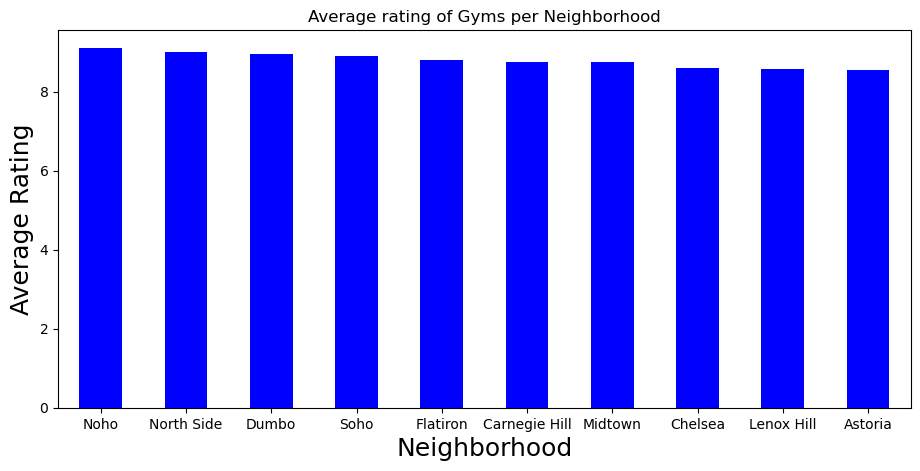

In [25]:
Max = 10
plt.figure(figsize=(11,5), dpi = 100)
plt.title('Average rating of Gyms per Neighborhood')
plt.xlabel('Borough', fontsize = 18)
plt.ylabel('Average Rating', fontsize=18)
gym_stats_ny.groupby('Neighborhood')['Rating'].mean().nlargest(Max).plot(kind='bar', color='blue')
plt.xticks(rotation = 'horizontal')
plt.show()

### What borough has the best gyms based on their average ratings?

In [26]:
ny_borough_stats=gym_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats['Likes']=gym_stats_ny.groupby('Borough',as_index=False).sum()[['Likes']]
ny_borough_stats.columns=['Borough','Average Rating','Likes']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating,Likes
2,Manhattan,7.791667,4380.0
1,Brooklyn,6.233333,534.0
0,Bronx,5.655556,74.0
3,Queens,5.363158,322.0
4,Staten Island,3.433333,82.0


### Lets graph the results

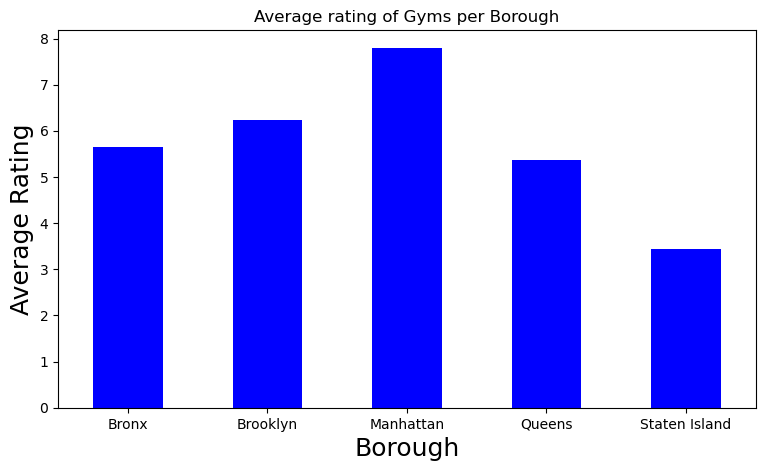

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Gyms per Borough')
plt.xlabel('Borough', fontsize = 18)
plt.ylabel('Average Rating', fontsize=18)
gym_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color='blue')
plt.xticks(rotation = 'horizontal')
plt.show()

#### We can see from these results that Manhattan besides having the most amount of gyms has the best gyms with a 7.8 average rating.

#### We'll consider the neighborhoods with an average rating higher than 7.0 and look at them in the new york map

Also to give us a better perspective of what the new york map is showing us we will integrate the total population of each borough acquired from [census.gov](https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219)

In [28]:
Borough_Population = pd.read_csv('Borough Population.csv', index_col = 0)
Borough_Population.head()

,Population
Borough,
Bronx,1418207
Brooklyn,2559903
Manhattan,1628706
Queens,2253858
Staten Island,476143


In [ ]:
Borough_Population.plot.bar(figsize=(10,5), color='blue')
plt.ticklabel_format(style="plain", axis="y")
plt.title('Population per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 18)
plt.ylabel('Population', fontsize=18)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,NY_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    Borough = ny_neighborhood_stats.loc[ny_neighborhood_stats['Longitude'] == lng, 'Borough'].iloc[0]
    if Borough == 'Brooklyn':
        rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )
    elif Borough == 'Queens':
        rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='green',
            fill_opacity=0.6
        )
    )
    elif Borough == 'Manhattan':
        rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    elif Borough == 'Bronx':
        rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='orange',
            fill_opacity=0.6
        )
    )
    else:
        rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='purple',
            fill_opacity=0.6
        )
    )   

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)


# Conclusion/Results

After taking a look at all the data we have learned several things, first The best and also the most gyms in New York city are located in Manhattan with the Equinox Soho and the Equinox East 92nd Street as notable mentions with the highest amount of likes and the higuest rating respectively of all the gyms in the city. Currently the most Gyms are in Manhattan but if we take into consideration the population of each borough and the population that now work from home due to covid-19 several places come into mind as good places to open a new gym and each with its advantages and disadvantages.

 - Opening a Gym in Manhattan. Manhattan as mentioned before is currently the go to place for the best gyms, but new gyms in this area would be up to a fierce competition due to the amount of gyms that are already present in the area, but if investors believe they can be up to the challenge a new gym in the borough will have their clientele assured.
 
 - Opening a Gym in Brooklyn. This Borough has a higher population than any other so taking into account the previously mentioned population working from home, along with the fact that this borough has few gyms with high rating in them, and the ones they have are closer to the Manhattan Borough, this conditions offer a great oportunity for new gyms, some good neighborhoods for this posible gym could be Flatbush, Kensington or prospect lefferts gardens all with a somewhat centric location in Brooklyn.